# Dataset pipeline testing

This notebook contains all the data pipeline operations and usage of the data module from the custom library. The dataset pipline has been built using [torchio](https://torchio.readthedocs.io/), which is a library that comes with amazing preprocessing, augmentation transforms, and dataset implementations that can directly ported for MRI images

## Necesssary Imports

In [1]:
import torch
import numpy as np
import torchvision
import torchio as tio
from lib.data import *
from lib.utils import *
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from pathlib import Path

Create the dataset paths for the iamges and labels (masks)

In [2]:
root = Path('data')
images_dir = root / 'images'
labels_dir = root / 'labels'

images = sorted(images_dir.glob('*.nii.gz'))
labels = sorted(labels_dir.glob('*.nii.gz'))

Use the `get_dataset_from_path` function to load the folders as a Subject dataset which basically contains hashmaps under the required names. Refer `lib/data.py` for the fucntion's implementation.

* Subject
    * mri - MRI Image of the skull
    * brain - Mask image

In [3]:
dataset = get_dataset_from_path(images, labels)

Visualize some samples from the the loaded dataset

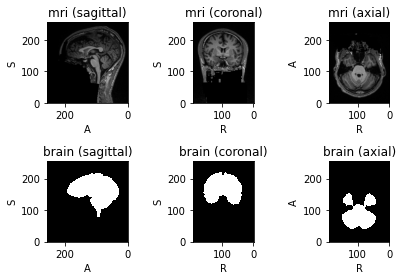

ScalarImage(shape: (1, 256, 256, 192); spacing: (1.00, 1.00, 1.00); orientation: PIR+; memory: 48.0 MiB; dtype: torch.FloatTensor)
LabelMap(shape: (1, 256, 256, 192); spacing: (1.00, 1.00, 1.00); orientation: PIR+; memory: 48.0 MiB; dtype: torch.FloatTensor)
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [4]:
a = dataset[0]
a.plot()
print(a.mri)
print(a.brain)
print(type(a.mri.data))
print(type(a.brain.data))

We can see that our images in our dataset are 3-dimensional and they are in the 1mm space. A single image is taking arounf 48.0 MB to reside in the memory

## Histogram Intensity 

Plot the histogram intensity values of the MRI images present in the dataset. This tells us about the intensity variation of the MRI volumes present in each image of the dataset. We can use histogram intensity normalization technqiues to normalize the intensity valeus of the images as well as standardize the histograms in a given image.

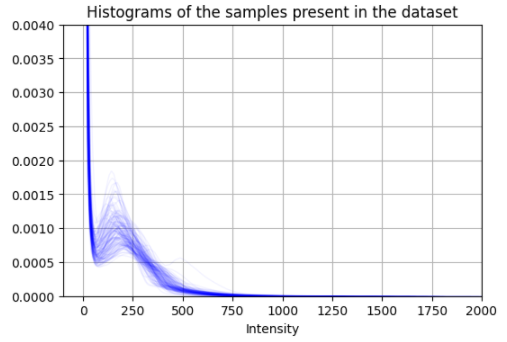

In [5]:
# get_histogram_plot(dataset)
display.Image('images/histogram_intensity_in_dataset.png')

Normalize the intensity of the images present in the dataset using the `train_histograms` method from `lib/utils.py` which gives us the normalized intensity image's mean and std that can be used during preporcessing

In [6]:
landmarks_path = 'NFBS_histogram_landmarks.npy'
# train_histograms(images, landmarks_path)

We can see that the curve is smoothened after histogram intensity normalization, which gives better results during training and inference

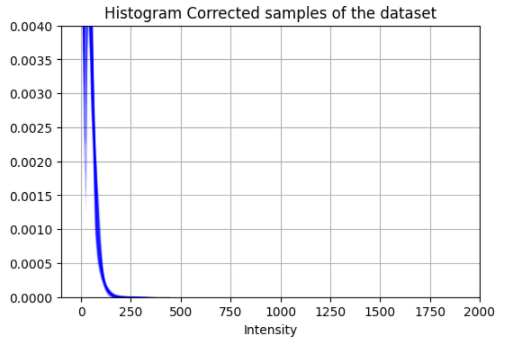

In [18]:
# get_histogram_plot(dataset, use_histogram_landmarks=True, landmarks_path=landmarks_path)
display.Image('images/histogram_corrected_intensity_in_dataset.png')

## Data pipelines

### Dataset - Whole Images

In this type of pipeline the MRI images are preprocessed and applied augmentations like resampling, histogram standardization, random bias field generation, z-normalization, random noise, random flip, etc. These images are loaded as a whole and can consume a lot of residing and processing memory. Here we have used 20% of the data for validation.

In [8]:
training_set, validation_set = load_datasets(images, labels, volume="whole", test_size=0.2)

Volume Mode: WHOLE | Dataset: 125 Images
Training set: 100 Images
Validation set: 25 Images


Plot samples from the loaded whole images training set

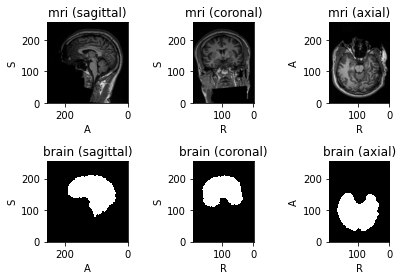

ScalarImage(shape: (1, 192, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 48.0 MiB; dtype: torch.FloatTensor)
LabelMap(shape: (2, 192, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 96.0 MiB; dtype: torch.FloatTensor)


In [9]:
a = training_set[14]
a.plot()
print(a.mri)
print(a.brain)

Plot samples from the loaded whole images validation set

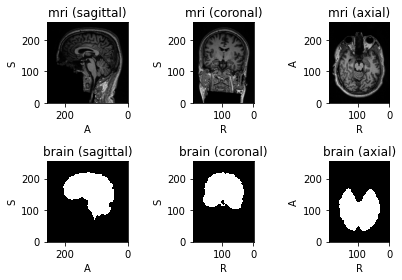

ScalarImage(shape: (1, 192, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 48.0 MiB; dtype: torch.FloatTensor)
LabelMap(shape: (2, 192, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 96.0 MiB; dtype: torch.FloatTensor)


In [10]:
a = validation_set[5]
a.plot()
print(a.mri)
print(a.brain)

Create the data loaders for the dataset

In [11]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=4)

Plot some samples as a grid to see the transformations on images and the masks

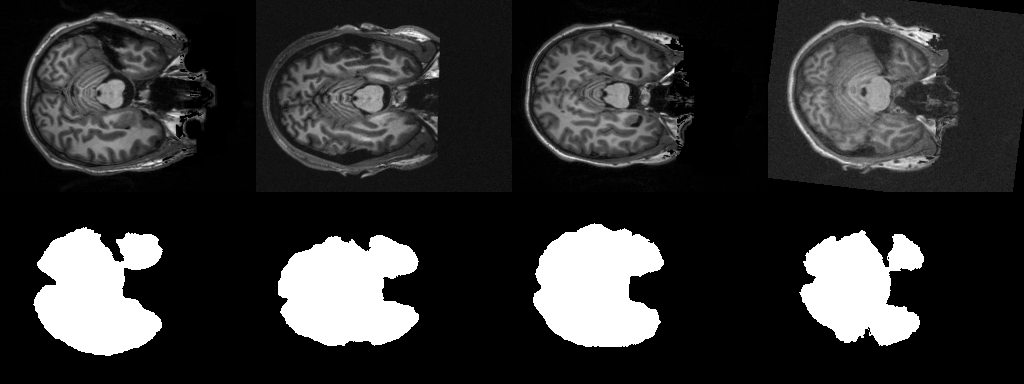

In [12]:
k = 128
batch = next(iter(train_loader))
batch_mri = batch['mri'][tio.DATA][..., k]
batch_label = batch['brain'][tio.DATA][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_whole_images.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=4,
    normalize=True,
    scale_each=True,
    padding=0,
)
display.Image(image_path)

Here we can see that random noise, elastic deformation, etc. augmentations have been applied on the training set and the whole iamges pipeline uses a lot of memory

### Dataset - Sub-Volumes (Patches)

In this dataset pipeline the whole iamges dataset is broken down into random sub-volumes or patches of a given size which can be aggregated into whole images later. This can save a lot of memory as well as the model can perform better as it sees the MRI images in different patches leading to better performance. Here we're using a test size of 20 % and a patch size of 128 which would give us randomized (128, 128, 128) sized sub-volumes from the dataset

In [13]:
training_set, validation_set = load_datasets(images, labels, patch_size=128, volume="patches", test_size=0.2)

Volume Mode: PATCHES | Dataset: 125 Images
Training set: 12800 Images
Validation set: 3200 Images


Visualize some samples from the sub-volume based training set

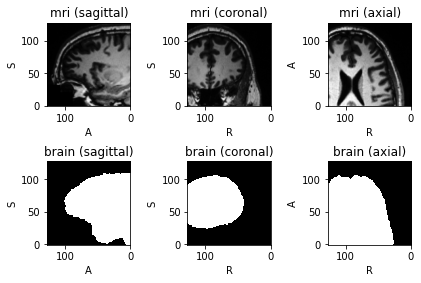

ScalarImage(shape: (1, 128, 128, 128); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 8.0 MiB; dtype: torch.FloatTensor)
LabelMap(shape: (2, 128, 128, 128); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 16.0 MiB; dtype: torch.FloatTensor)


In [14]:
a = training_set[14]
a.plot()
print(a.mri)
print(a.brain)

As we can see it takes only 8 MB for a single patch thus, saving a lot of memory

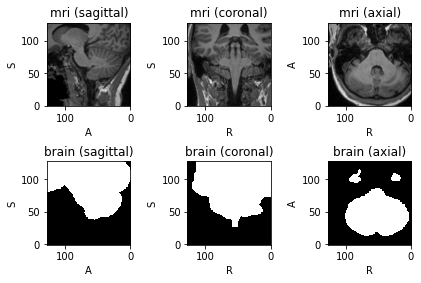

ScalarImage(shape: (1, 128, 128, 128); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 8.0 MiB; dtype: torch.FloatTensor)
LabelMap(shape: (2, 128, 128, 128); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 16.0 MiB; dtype: torch.FloatTensor)


In [15]:
a = validation_set[5]
a.plot()
print(a.mri)
print(a.brain)

Create dataloaders for the sub-volume based dataset

In [16]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=4)

Visualize the sub-volumes as a grid

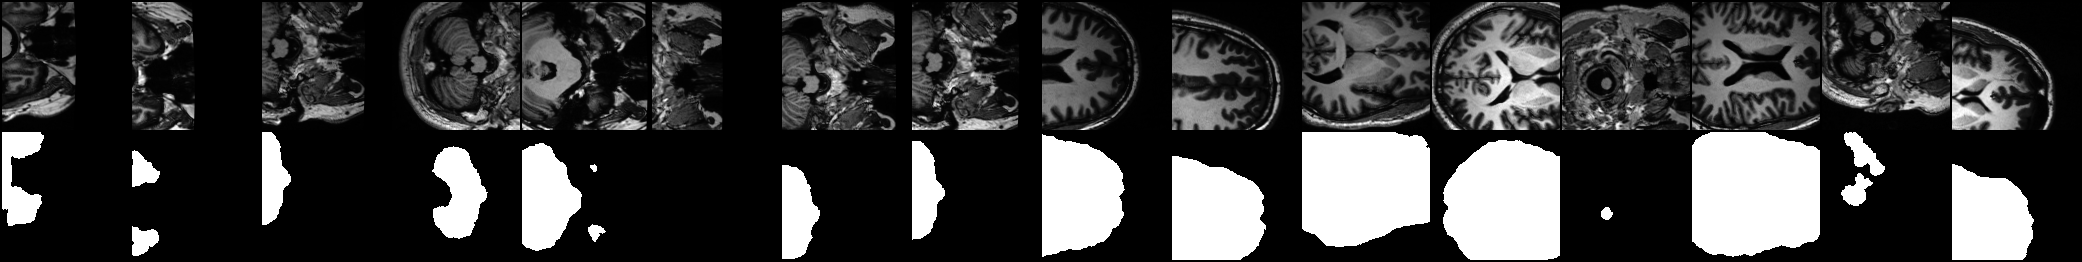

In [17]:
k = 80
for _ in range(2): batch = next(iter(train_loader))
batch_mri = batch['mri'][tio.DATA][..., k]
batch_label = batch['brain'][tio.DATA][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=16,
    normalize=True,
    scale_each=True,
)
display.Image(image_path)

## Conclusion

We saw the diffrent data pipelines from the custom library. It is better to use patch-based pipeline (sub-volumes) since it saves a lot of memory and the model can perform better